In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
# activate DSAI-py364-tf-gpu

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

In [3]:
def safely_mkdir(dirPath:str):
    '''安全地生成目錄，若目錄已存在則無動作'''
    if os.path.exists(dirPath):
        print("Directory is exist.")
    os.makedirs(dirPath, exist_ok=True) 
    return dirPath

def printlog(msg:str, dirPath:str, mode='a', sep=' ', end='\n', flush=False):
    '''print to std.out and 
    write to log file at the same time'''
    print(msg, sep=sep, end=end, flush=flush)
    with open(dirPath, mode=mode) as f:
        print(msg, file=f, sep=sep, end=end, flush=flush)
    
    # Below is almost the same, but no newline mark at end of line.
    #with open(dirPath, mode=mode, encoding=encoding, newline=newline) as f:
    #    f.write(msg)
    


# 實驗全域變數設定

## 實驗日期與紀錄檔

In [4]:
# Get current date and time
datetime_thisRun = datetime.now() 

In [5]:
# Loggering dirName
log_dirName = f'log/{datetime_thisRun.strftime("%Y_%m_%d__%H_%M_%S")}'
# Make dir of Loggering
safely_mkdir(log_dirName)
# log datetime
printlog(f"Date: {datetime_thisRun}", f'{log_dirName}/log.txt')

Date: 2022-03-28 16:56:04.359530


## 亂數種子設定
每次重新匯入 numpy (或改寫 random.seed) 時，都會創建一張固定的亂數表<br>
接著只要執行任一種隨機抽樣函式，就會基於原本的亂數表重新制定第二張亂數表<br>
至此，往後呼叫任何隨機抽樣函式都會根據第二張亂數表去依序給予亂數<br>
numpy 預設的隨機種子會讓每次生成的第二張亂數表都不一樣 (猜測有可能是加入當地時間種子?沒有細查)<br><br>
有趣的是，只要固定隨機種子 (np.random.seed) 就能發現第二張亂數表的生成會變成是固定的<br>
故可以用 numpy 預設的擬真亂數來產生亂數種子，並將其重設亂數種子。<br>
如此一來便能追蹤本次的亂數種子設定，使實驗可以復刻，同時也維持高度擬真的隨機性。

In [6]:
# 使用 random BitGenerator 隨機生出一個介於 0 ~ 2**32-1 的整數
rng = np.random.default_rng()
myseed = rng.integers(0b11111111111111111111111111111111, size=1) # numpy seed 為 unsign int32 
printlog(f"Random seed: {myseed}", f'{log_dirName}/log.txt')

np.random.seed(seed = myseed) # follow MT19937 by default, seed range is 0 ~ 2**32 - 1
tf.random.set_seed(myseed)

Random seed: [3108386283]


# Import Data and Preprocessing
(規劃與分析)
* 我們只要預測 4 月中旬之前，所以不需要 5 月份以後的資料
* 過年期間的資料要去掉
* 過去大停電的資料要去掉

---
* 由於 備轉容量 = 系統運轉淨尖峰能力－系統瞬時尖峰負載<br>
  因此我們的模型只要能抓到 系統運轉淨尖峰能力 及 系統瞬時尖峰負載的「變化趨勢」，再相減<br>
  應該就能得到正確的備轉容量
* 方案1: 先 train 好兩種趨勢的 GRU，再加上 DNN 
* 方案2: GRU 跟 DNN 一起 Train

---
* 訓練資料: 清明節前後、特殊假日、1~4月資料
* 驗證資料: ? 2019 或 2020 的4月份資料
* 最終測試資料: 03/30~4/13 (連價前3天、清明連假、清明節後一周)
## Preprocessing
* 從 Github 找到學長姐過去的資料得到 2019 ~ 2021 年的過去電力供需資訊
* 然而發現學長姐當時的資料有所欠缺或儲存值單位有誤，故 Operating Reserve 的欄位<br>使用「台灣電力公司 近三年每日尖峰備轉容量率」資料進行校正，並將中文欄位名稱改為台電官方英文用語，最終產物為「Assembled_Power_Information.csv」

In [158]:
preprocessed_dataset_dirPath = './dataset/preprocessed_dataset'
df = pd.read_csv(f'{preprocessed_dataset_dirPath}/Assembled_Power_Information.csv')

In [159]:
df.head()

,Date Time,Week,Net Peaking Capability (MW),Peak Load (MW),Operating Reserve (MW)
0,20190101,2,26429,23872,2557.3
1,20190102,3,30047,28148,1899.5
2,20190103,4,30343,28452,1891.6
3,20190104,5,30301,28490,1811.1
4,20190105,6,27957,26054,1902.7


In [160]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%Y%m%d')
date_time

0      2019-01-01
1      2019-01-02
2      2019-01-03
3      2019-01-04
4      2019-01-05
          ...    
1150   2022-02-24
1151   2022-02-25
1152   2022-02-26
1153   2022-02-27
1154   2022-02-28
Name: Date Time, Length: 1155, dtype: datetime64[ns]

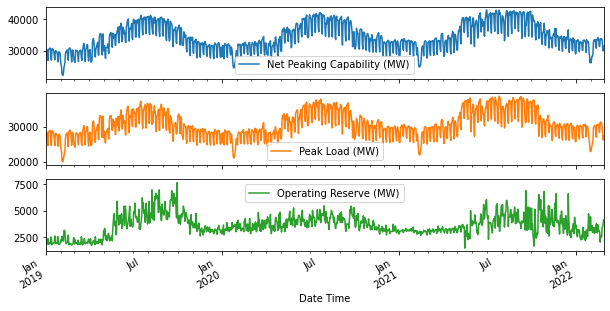

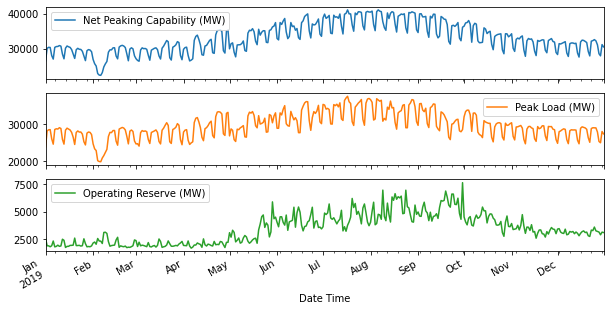

In [161]:
plot_cols = ['Net Peaking Capability (MW)', 'Peak Load (MW)', 'Operating Reserve (MW)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:365]
plot_features.index = date_time[:365]
_ = plot_features.plot(subplots=True)

In [162]:
# Inspect and cleanup
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Week,1155.0,4.000000,2.000866,1.0,2.0,4.0,6.000,7.0
Net Peaking Capability (MW),1155.0,34197.608658,4253.766153,22258.0,31258.0,33522.0,37462.500,42878.0
Peak Load (MW),1155.0,30589.774026,3780.176064,19936.0,28152.5,30088.0,33071.000,38844.0
Operating Reserve (MW),1155.0,3607.953366,996.564553,1437.0,3039.9,3471.0,4155.335,7656.8


In [163]:
# Feature engineering
## Time: Time info. is vital, converting it to seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s

0       1.546301e+09
1       1.546387e+09
2       1.546474e+09
3       1.546560e+09
4       1.546646e+09
            ...     
1150    1.645661e+09
1151    1.645747e+09
1152    1.645834e+09
1153    1.645920e+09
1154    1.646006e+09
Name: Date Time, Length: 1155, dtype: float64

In [164]:
# Get signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of year signal')

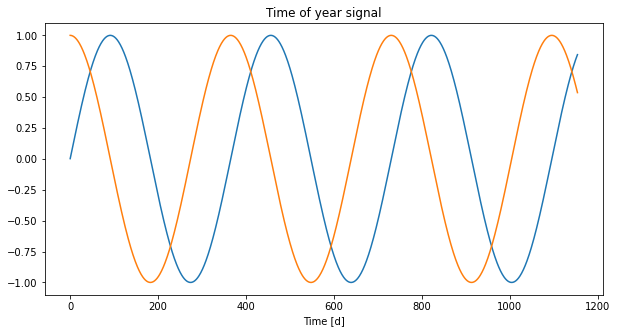

In [165]:
plt.plot(np.array(df['Year sin'])[:1155])
plt.plot(np.array(df['Year cos'])[:1155])
plt.xlabel('Time [d]')
plt.title('Time of year signal')

In [166]:
from scipy.fft import fft, fftfreq

In [167]:
def MyFFT(fftInput, hamming, T):
    if hamming:
        fftInput = fftInput * np.hamming(len(fftInput)) # hamming窗函數，減少頻率洩漏

    N = len(fftInput) # Number of sample points
    # T = 1.0 / 9.0 # sample spacing # 應使用傳入值T
    ## x = np.linspace(0.0, N*T, N, endpoint=False)
    y = fftInput
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    yf_regular = 2.0/N * np.abs(yf[0:N//2])


    return xf, yf_regular #*1.85 #漢明窗振幅補償

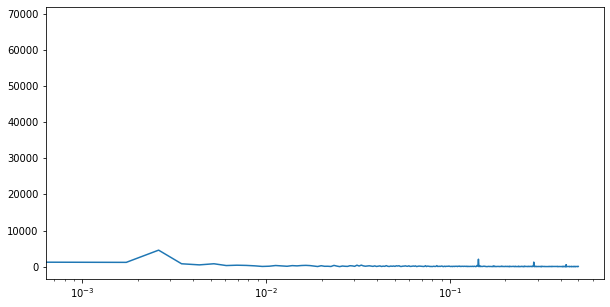

In [168]:
xf, yf_regular = MyFFT(df['Net Peaking Capability (MW)'].to_numpy(), 0, 1) # 單位=day
plt.xscale('log')
plt.plot(xf, yf_regular)

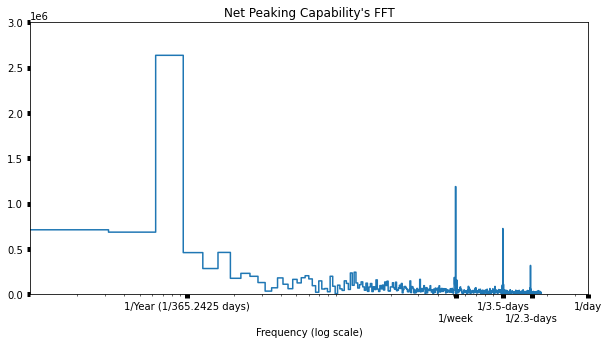

In [169]:
fft = tf.signal.rfft(df['Net Peaking Capability (MW)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['Net Peaking Capability (MW)'])
days_per_year = 365.2425
years_per_dataset = n_samples_d/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.title("Net Peaking Capability's FFT")
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 3000000)
plt.xlim([0.1, max(plt.xlim())])
plt.tick_params(width=5)
plt.xticks([1, days_per_year/7, days_per_year/3.5, days_per_year/2.3, days_per_year], 
           labels=['1/Year (1/365.2425 days)', '\n1/week', '1/3.5-days', '\n1/2.3-days', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

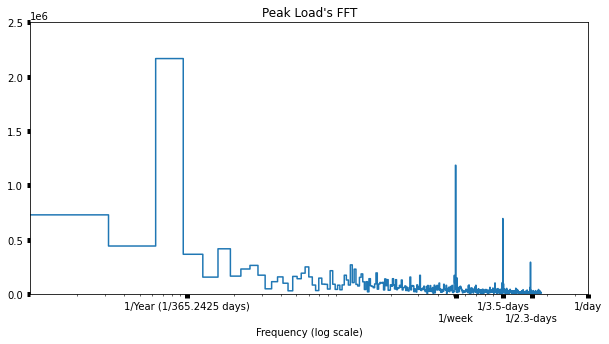

In [170]:
fft = tf.signal.rfft(df['Peak Load (MW)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['Peak Load (MW)'])
days_per_year = 365.2425
years_per_dataset = n_samples_d/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.title("Peak Load's FFT")
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2500000)
plt.xlim([0.1, max(plt.xlim())])
plt.tick_params(width=5)
plt.xticks([1, days_per_year/7, days_per_year/3.5, days_per_year/2.3, days_per_year], 
           labels=['1/Year (1/365.2425 days)', '\n1/week', '1/3.5-days', '\n1/2.3-days', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

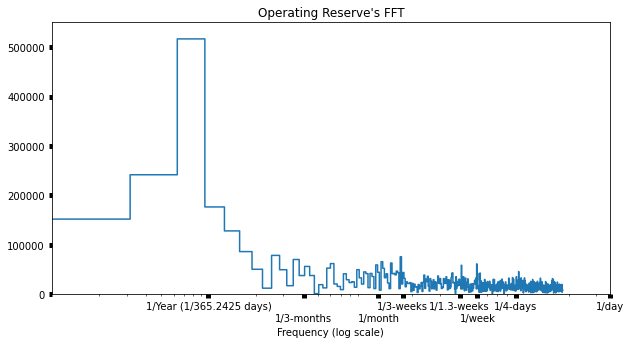

In [171]:
fft = tf.signal.rfft(df['Operating Reserve (MW)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(df['Operating Reserve (MW)'])
days_per_year = 365.2425
years_per_dataset = n_samples_d/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.title("Operating Reserve's FFT")
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 550000)
plt.xlim([0.1, max(plt.xlim())])
plt.tick_params(width=5)
plt.xticks([1, days_per_year/90, days_per_year/30, days_per_year/21, days_per_year/(7*1.3), days_per_year/7, days_per_year/4, days_per_year], 
           labels=['1/Year (1/365.2425 days)', '\n1/3-months', '\n1/month', '1/3-weeks', '1/1.3-weeks', '\n1/week', '1/4-days', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [172]:
# 由 FFT 可以發現，顯然 Net Peaking Capability 與 Peak Load 除了年呈現週期性變化之外，
# 每一周、每 3.5天、每 2.5 天 (推測是假日或節期)，也會呈現週期性變化
# 直接對照真實日期會發現大致上 (週日至週一) 的 Peak Load 會特別低、(週二至週六) 的 Peak Load 會特別高
# 雖然不知為何台電不直接顯示 Net Peaking Capability 趨勢，但從本實驗中可發現 Net Peaking Capability 大致上是跟著 Peak Load 變化
# 畢竟如果是用電的人少的日子，也不用開這麼多機組待命?
# 因此由 RNN 行訓練時，因將 7天、3.5天、2.5天 各視為一個合理的變化區段，或說預期 RNN 能找到每周固定的變化規律
# 如此一來， input feature 除了前一周的 Net Peaking Capability、Peak Load，也應該包含星期幾

## 刪除離群值、歧異值、級特殊事件、與現況不符等的時間區段
* 年假之全國大停工期間，資料刪去: 
    * 2022/1/25 ~ 2022/2/7 
    * 2021/2/9 ~ 2021/2/17
    * 2020/1/21 ~ 2020/2/3
    * 2019/1/29 ~ 2019/2/11
* [2021、2022 大停電](https://zh.wikipedia.org/wiki/%E5%8F%B0%E7%81%A3%E5%A4%A7%E5%81%9C%E9%9B%BB%E5%88%97%E8%A1%A8)資料刪去
    * 2021 年 5 月 13 日 (2021/5/11 ~ 2021/5/17)
    * 2021 年 5 月 17 日 (2021/5/11 ~ 2021/5/17)
    * 2022 年 3 月  3 日 (2022/3/1 ~ 2022/3/7)
* [2021 年中華民主共和國 (Republic of China) 全國疫情第三級警戒](https://zh.wikipedia.org/wiki/2021%E5%B9%B4%E4%B8%AD%E8%8F%AF%E6%B0%91%E5%9C%8B%E5%85%A8%E5%9C%8B%E7%96%AB%E6%83%85%E7%AC%AC%E4%B8%89%E7%B4%9A%E8%AD%A6%E6%88%92)，現在疫情趨向穩定，與三級緊戒疫情居家辦公型態不同，資料刪去
    * 2021/5/15 ~ 2021/7/27 (三級降二級)
    * 2021/10/08 紙本振興五倍券第一批開放領取
    * [2021/10/27 我國疫苗第一劑注射率達 70%、第二劑達 30%](https://covid19.mohw.gov.tw/ch/sp-timeline0-205.html) 表示疫情逐漸趨緩
    * 刪去 (2021/5/11 ~ 2021/11/1)

In [173]:
data_train = pd.read_csv(f'{preprocessed_dataset_dirPath}/Assembled_Power_Information_train.csv')
data_train.head()

,Date Time,Week,Net Peaking Capability (MW),Peak Load (MW),Operating Reserve (MW),Low Consumption,High Consumption
0,20190101,2,26429,23872,2557.3,0,1
1,20190102,3,30047,28148,1899.5,0,1
2,20190103,4,30343,28452,1891.6,0,1
3,20190104,5,30301,28490,1811.1,0,1
4,20190105,6,27957,26054,1902.7,0,1


In [ ]:
data_train_x = data_train[] #!!!!!!!!!!! 思考如何有效率地塞入7天資料預測後7天資料
data_train_x

In [ ]:
data_train_y = data_train[] #!!!!!!!!!!! 思考如何有效率地塞入7天資料預測後7天資料
data_train_y

In [174]:
data_vali = pd.read_csv(f'{preprocessed_dataset_dirPath}/Assembled_Power_Information_valid.csv')
data_vali.head()

,Date Time,Week,Net Peaking Capability (MW),Peak Load (MW),Operating Reserve (MW),Low Consumption,High Consumption
0,20200331,2,32484,29162,3321.6,0,1
1,20200401,3,32373,28278,4094.7,0,1
2,20200402,4,29551,25443,4108.1,0,1
3,20200403,5,28869,25120,3748.9,0,1
4,20200404,6,28652,24238,4414.2,0,1


In [ ]:
# 再製作一個 train 純粹容量率預測的模型 及 DNN

# Build Model and Train

In [ ]:
def Build_GRUModel(input_dims, output_dims, name):
    '''Functional API format: 
    keras functional api is a highly customizable design.
    This is Kuihao's style model builder.'''
    # Define input layer with shape 
    input_layer = tf.keras.Input(shape=input_dims, name='input_layer') 

    # Construct NN connections
    x = input_layer # apply to input layer
    x = tf.keras.layers.GRU(units=24, name='gru_layer1', batch_input_shape=(None, 28, 1), dtype='float32', return_sequences=True, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False,  use_bias=True)(x)
    #x = tf.keras.layers.GRU(name='gru_layer2', trainable=True, batch_input_shape=(None, 28, 1), dtype='float32', return_sequences=True, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False, units=21, use_bias=True)(x)
    #x = tf.keras.layers.GRU(name='gru_layer3', trainable=True, batch_input_shape=(None, 28, 1), dtype='float32', return_sequences=True, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False, units=18, use_bias=True)(x)
    #x = tf.keras.layers.GRU(name='gru_layer4', trainable=True, batch_input_shape=(None, 28, 1), dtype='float32', return_sequences=True, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False, units=15, use_bias=True)(x)
    #x = tf.keras.layers.GRU(name='gru_layer5', trainable=True, batch_input_shape=(None, 28, 1), dtype='float32', return_sequences=True, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False, units=11, use_bias=True)(x)
    #x = tf.keras.layers.GRU(name='gru_layer6', trainable=True, batch_input_shape=(None, 28, 1), dtype='float32', return_sequences=True, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False, units=8, use_bias=True)(x)
    #x = tf.keras.layers.GRU(name='gru_layer7', trainable=True, batch_input_shape=(None, 28, 1), dtype='float32', return_sequences=True, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False, units=5, use_bias=True)(x)
    #x = tf.keras.layers.GRU(name='gru_layer8', trainable=True, batch_input_shape=(None, 28, 1), dtype='float32', return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, time_major=False, units=2, use_bias=True)(x)
    output_layer = tf.keras.layers.Dense(output_dims, name='output_layer')(x) # apply to outout layer with shape

    return tf.keras.Model(inputs=input_layer, outputs=output_layer, name=name)

In [ ]:
# Create an instance of the model
test_model = Build_GRUModel(input_dims=(28, 24), output_dims=8, name='TEST')
test_model.summary()

In [ ]:
'''----------------------------------------------'''

In [ ]:
# You can write code above the if-main block.
if __name__ == '__main__':
    # You should not modify this part, but additional arguments are allowed.
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument('--training',
                       default='training_data.csv',
                       help='input training data file name')

    parser.add_argument('--output',
                        default='submission.csv',
                        help='output file name')
    args = parser.parse_args()

    # The following part is an example.
    # You can modify it at will.
    df_training = pd.read_csv(args.training)
    model = Model()
    model.train(df_training)
    df_result = model.predict(n_step=7)
    df_result.to_csv(args.output, index=0)
# python app.py --training training_data.csv --output submission.csv